In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/data/user_ratings.csv')
df = df[['Username','BGGId','Rating']]
df.head()

,Username,BGGId,Rating
0,Tonydorrf,213788,8.0
1,tachyon14k,213788,8.0
2,Ungotter,213788,8.0
3,brainlocki3,213788,8.0
4,PPMP,213788,8.0


In [4]:
game_df = pd.read_csv('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/data/games.csv')

In [11]:
df['Username'] = df['Username'].astype(str)
df['BGGId'] = df['BGGId'].astype(int)
df['Rating'] = df['Rating'].astype('float32')

In [12]:
user_ids = df['Username'].unique().tolist()
game_ids = df['BGGId'].unique().tolist()

In [13]:
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
game2game_encoded = {x: i for i,x in enumerate(game_ids)}

In [14]:
num_users = len(user2user_encoded)
num_games = len(game2game_encoded)

In [15]:
df['user'] = df['Username'].map(user2user_encoded)
df['game'] = df['BGGId'].map(game2game_encoded)
df['Rating'] = df['Rating'].values.astype(np.float32)

In [16]:
min_rating = min(df['Rating'])
max_rating = max(df['Rating'])
X = df[['user','game']].values
y = df[['Rating']]

In [25]:
scaler = MinMaxScaler()
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
y_train, y_test = scaler.fit_transform(y_train), scaler.transform(y_test)

In [198]:
embeddings_size = 50

user_input = Input(name='user_input', shape=(1,))
user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embeddings_size)(user_input)
user_vec = Flatten(name='flatten_user')(user_embedding)

game_input = Input(name='game_input', shape=(1))
game_embedding = Embedding(name='game_embedding', input_dim = num_games, output_dim = embeddings_size)(game_input)
game_vec = Flatten(name='reshaped_game')(game_embedding)

prod = Dot(name='dot_product',normalize=True, axes=1)([user_vec, game_vec])

y_out = Dense(name='y_out', units=1, activation='linear')(prod)


model = Model(inputs=[user_input, game_input], outputs=y_out)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 game-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user-embedding (Embedding)     (None, 1, 50)        20568750    ['user-input[0][0]']             
                                                                                                  
 game-embedding (Embedding)     (None, 1, 50)        1096250     ['game-input[0][0]']             
                                                                                            

In [199]:
history = model.fit(x=[x_train[:,0], x_train[:,1]], y=y_train, epochs=3, batch_size = 5000, verbose=True)

Epoch 1/3
3031/3031 [==============================] - 672s 221ms/step - loss: 0.0644 - mean_squared_error: 0.0644
Epoch 2/3
3031/3031 [==============================] - 674s 222ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 3/3
3031/3031 [==============================] - 693s 229ms/step - loss: 0.0115 - mean_squared_error: 0.0115


Text(0.5, 0, 'epoch')

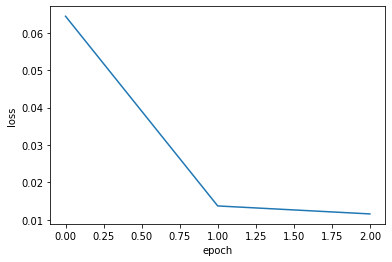

In [200]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

In [201]:
y_pred = model.predict(x=[x_test[:,0], x_test[:,1]])

118389/118389 [==============================] - 81s 680us/step


In [202]:
mean_squared_error(y_test, y_pred, squared=False)

0.120762445

In [207]:
model.save('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/src/models/nn_model')

INFO:tensorflow:Assets written to: C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/src/models/nn_model\assets


INFO:tensorflow:Assets written to: C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/src/models/nn_model\assets


In [9]:
saved_model = tf.keras.models.load_model('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/src/models/nn_model')

In [18]:
y_save = saved_model.predict(x=[x_test[:,0], x_test[:,1]])

118389/118389 [==============================] - 83s 699us/step


In [19]:
mean_squared_error(y_test, y_save, squared=False)

0.11721588

In [20]:
def user_recommendations(user, n_games,model):
    """
        Takes in a user, n_games and a model to returns their top n_games recommendations that they have not rated yet.

        Parameters:
            user(str): name of user
            n_games(int): number of games to show
            model: the model to use for predictions
            
        Returns:
            A list with each game as an index with a column for their estimated rating
    """
    # Remove the boardgames that the user have rated
    boardgame_id = df['BGGId'].unique()
    user_list = df.loc[df['Username']==user, 'BGGId']
    user_list = np.setdiff1d(boardgame_id, user_list)

    # Create sparse dataset with username and bggid
    testset = np.array([[user2user_encoded[user], game2game_encoded[bggid]] for bggid in user_list])
    # Test model on the testset and determine the boardgames with the highest rating
    predictions = model.predict(x=[testset[:,0],testset[:,1]])
    # Reshaped the predictions array by Transposing it. 
    top_ratings_idx = predictions.T[0].argsort()[::-1][:n_games]
    bgg_ids = user_list[top_ratings_idx]
    bgg_name = [game_df.loc[game_df['BGGId'] ==id]['Name'].values[0] for id in bgg_ids]
    print(f'Top boardgames for {user} in order are: \n {bgg_name}')
    

In [21]:
user_recommendations('bennygui',5, saved_model)

673/673 [==============================] - 1s 728us/step
Top boardgames for bennygui in order are: 
 ['Escape Room in a Box: The Walking Dead', 'Galaxy Trucker', 'Oltréé', 'Exit: The Game – Advent Calendar: The Mystery of the Ice Cave', 'The Phoenix Syndicate']


In [7]:
df[df['Username'] == 'bennygui'].sort_values('Rating',ascending=False)

,Username,BGGId,Rating
8087363,bennygui,157354,9.0
9912510,bennygui,54043,9.0
11513927,bennygui,176494,9.0
4144866,bennygui,68448,9.0
11778938,bennygui,283948,9.0
...,...,...,...
18389978,bennygui,169675,4.0
5908835,bennygui,163968,4.0
12769854,bennygui,36381,4.0
17299685,bennygui,196379,4.0
